# Configuration

In [1]:
# Model Configuration
CONTEXT_LENGTH = 512  # Fixed context length for chunks
EMBEDDING_DIM = 256  # Dimension of the token embeddings
NUM_HEADS = 8  # Number of attention heads
NUM_LAYERS = 6  # Number of transformer layers
QK_HEAD_DIM = 32  # Dimension of the query and key heads
V_HEAD_DIM = 64  # Dimension of the value head
MLP_DIM = 1024  # Dimension of the hidden layers in the transformer

# EMBEDDING_DIM = 128  # Dimension of the token embeddings
# NUM_HEADS = 4  # Number of attention heads
# NUM_LAYERS = 1  # Number of transformer layers
# QK_HEAD_DIM = 8  # Dimension of the query and key heads
# V_HEAD_DIM = 16  # Dimension of the value head
# MLP_DIM = 512  # Dimension of the hidden layers in the transformer

# Data Configuration
VOCAB_SIZE = 1024  # Size of the vocabulary
PADDING = True # Whether to pad sequences
PACKING = True # Whether to pack sequences for training

# Training Configuration
SEED = 42  # Random seed for reproducibility
BATCH_SIZE = 128  # Batch size for training
EPOCHS = 20 # Number of epochs to train
SAMPLE_LIMIT = 100000  # Set to None to process the entire dataset
LR = 0.001  # Learning rate for the optimizer
WEIGHT_DECAY = 0.01  # Weight decay for the optimizer
BETA1 = 0.9  # Beta1 for the Adam optimizer
BETA2 = 0.999  # Beta2 for the Adam optimizer

# File Paths and Labels
TOKENIZER_FILE = "./data/tinystories-tokenizer"
CHUNK_FILE = "./data/chunked_stories"
LOG_DIR = None
# LOG_DIR = 'runs/2025-08-23_12-13-49'
DICT_LABEL = 'seq'

In [2]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
import mlx.data as dx

from datasets import load_dataset
from tokenizers import Tokenizer

from tensorboardX import SummaryWriter

from llm.modules import SmallLanguageModel, loss_fn, count_parameters, generate_story
from llm.data import train_tokenizer, chunk_story, data_to_array_of_dict, create_dict_parameters, encode_story, pack_stories, pretty_json

In [3]:
params = create_dict_parameters(locals())
LOG_DIR = f'runs/{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}' if LOG_DIR is None else LOG_DIR
writer = SummaryWriter(log_dir=LOG_DIR)
if len(list(Path(LOG_DIR).glob('events.out.tfevents.*'))) == 1:
    print(f"Logging parameters")
    writer.add_text('Parameters', pretty_json(params))

Logging parameters


# Tokenizer

In [4]:
tokenizer_path = f'{TOKENIZER_FILE}_{VOCAB_SIZE}_{SAMPLE_LIMIT}.json'
if os.path.exists(tokenizer_path):
    print(f"Tokenizer file {tokenizer_path} already exists. Skipping training.")
else:
    dataset = load_dataset("roneneldan/TinyStories", split="train")
    if SAMPLE_LIMIT:
        dataset = dataset.select(range(min(SAMPLE_LIMIT, len(dataset))))
    tokenizer = train_tokenizer(dataset, vocab_size=VOCAB_SIZE, special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]", "\n"])
    tokenizer.save(tokenizer_path)
    print(f"Tokenizer saved to {tokenizer_path}")

tokenizer = Tokenizer.from_file(tokenizer_path)
encoded = tokenizer.encode("Once upon a time, there was a little fox.\nIt lived in a forest and loved to explore.")

print("\n--- Testing the Tokenizer ---")
print("Tokens:", encoded.tokens)
print("IDs:", encoded.ids)
print("Decoded:", tokenizer.decode(encoded.ids, skip_special_tokens=True))

Tokenizer file ./data/tinystories-tokenizer_1024_100000.json already exists. Skipping training.

--- Testing the Tokenizer ---
Tokens: [' Once', ' upon', ' a', ' time,', ' there', ' was', ' a', ' little', ' fo', 'x', '.', '\n', ' It', ' lived', ' in', ' a', ' forest', ' and', ' loved', ' to', ' expl', 'ore.']
IDs: [286, 302, 116, 337, 257, 137, 116, 256, 683, 86, 19, 4, 269, 794, 176, 116, 966, 122, 367, 123, 631, 771]
Decoded: Once upon a time, there was a little fox. It lived in a forest and loved to explore.


# Chunking

Chunk file ./data/chunked_stories_1024_512_100000_padding.npz already exists. Skipping chunking.


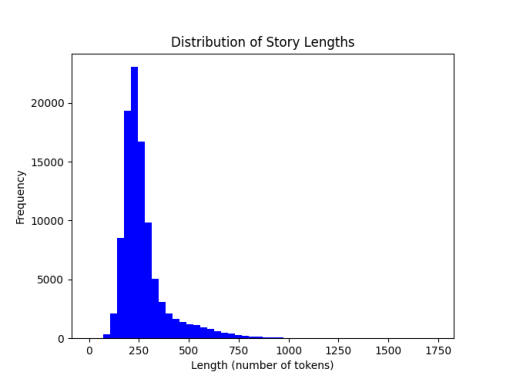

In [5]:
chunk_file_path = f'{CHUNK_FILE}_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{SAMPLE_LIMIT}_padding.npz' if PADDING else f'{CHUNK_FILE}_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{SAMPLE_LIMIT}.npz'
figure_path = f'./figures/histogram_{VOCAB_SIZE}_{SAMPLE_LIMIT}.png'
if os.path.exists(chunk_file_path):
    print(f"Chunk file {chunk_file_path} already exists. Skipping chunking.")

    # display the existing histogram
    plt.imshow(plt.imread(figure_path))
    plt.axis('off')
else:
    # Load the tokenizer
    if not ('dataset' in locals()):
        dataset = load_dataset("roneneldan/TinyStories", split="train")
        if SAMPLE_LIMIT:
            dataset = dataset.select(range(min(SAMPLE_LIMIT, len(dataset))))
    tokenizer = Tokenizer.from_file(tokenizer_path)

    # Process all stories and collect chunks
    num_non_special_tokens = []
    all_chunks = []
    unfinished_chunk = []
    for story in tqdm(dataset["text"], desc="Chunking stories"):
        if PACKING:
            story_chunks, count = encode_story(story, tokenizer, '[SOS]', '[EOS]')
            all_chunks.append(story_chunks)
        else:
            story_chunks, unfinished_chunk, = chunk_story(story, tokenizer, '[SOS]', '[EOS]', CONTEXT_LENGTH,
                                                            unfinished_chunk=unfinished_chunk, padding=PADDING, pad_token='[PAD]')
            all_chunks.extend(story_chunks)
        num_non_special_tokens.append(count)

    # Convert list to numpy array for efficient storage
    if PACKING:
        chunks_array = np.array(pack_stories(all_chunks, CONTEXT_LENGTH, tokenizer.token_to_id('[PAD]')), dtype=np.int32)
    else:
        chunks_array = np.array(all_chunks, dtype=np.int32)
    unique_tokens, counts = np.unique(chunks_array, return_counts=True)

    # Print statistics
    print(f"Total tokens: {CONTEXT_LENGTH * chunks_array.shape[0]:,}")
    print(f"Total non-special tokens: {np.sum(counts[3:]):,}")
    print(f"Number of special tokens: {np.sum(counts[:3]):,}")
    print(f"Array shape: {chunks_array.shape}")

    # Save the chunks to a compressed file
    print(f"Saving chunks to {chunk_file_path}...")
    np.savez_compressed(chunk_file_path, chunks=chunks_array)
    print(f"Saved successfully! File size: {os.path.getsize(chunk_file_path) / (1024 * 1024):.2f} MB")
    text_info_path = f'./data/chunk_info_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{SAMPLE_LIMIT}_padding.txt' if PADDING else f'./data/chunk_info_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{SAMPLE_LIMIT}.txt'

    plt.hist(num_non_special_tokens, bins=50, color='blue')
    plt.title("Distribution of Story Lengths")
    plt.xlabel("Length (number of tokens)")
    plt.ylabel("Frequency")
    plt.savefig(figure_path)

    with open(text_info_path, 'w') as f:
        f.write(f"Sample limit: {SAMPLE_LIMIT:,}\n")
        f.write(f"Vocabulary Size: {VOCAB_SIZE:,}\n")
        f.write(f"Context length: {CONTEXT_LENGTH:,}\n")
        f.write(f"Number of chunks: {chunks_array.shape[0]:,}\n")
        f.write(f"Number of tokens: {CONTEXT_LENGTH * chunks_array.shape[0]:,}\n")
        f.write(f"Number of non-special tokens: {np.sum(counts[3:]):,}\n")
        f.write(f"Number of special tokens: {np.sum(counts[:3]):,}\n")
        f.write(f"Padding used: {PADDING}\n")
        f.write(f"Packing used: {PACKING}\n")

# Data Pipeline

In [6]:
mx.random.seed(SEED)
np.random.seed(SEED)
data = np.load(chunk_file_path)
dicts = data_to_array_of_dict(data['chunks'], name=DICT_LABEL)

assert type(dicts) == list
assert type(dicts[0]) == dict
assert type(dicts[0][DICT_LABEL]) == np.ndarray

buffer = dx.buffer_from_vector(dicts)
stream = buffer.to_stream().batch(BATCH_SIZE).shuffle(buffer_size=BATCH_SIZE*100).prefetch(8,1) # For mlx-data 0.0.2 the seed only works with 1 thread
num_batches = len(dicts) // BATCH_SIZE

In [7]:
for x in stream:
    print(x[DICT_LABEL].shape)
    print(type(x[DICT_LABEL]))
    text = tokenizer.decode(x[DICT_LABEL][0], skip_special_tokens=False).split(' ')
    for i in range(0, len(text), 30):
        print(' '.join(text[i:i+30]))
    text = tokenizer.decode(x[DICT_LABEL][BATCH_SIZE-1], skip_special_tokens=False).split(' ')
    for i in range(0, len(text), 30):
        print(' '.join(text[i:i+30]))
    break  # Just to test the first batch
stream.reset()

(128, 512)
<class 'numpy.ndarray'>
[SOS] Once upon a time there was a girl called Emily. Emily was only three years old and loved to explore and play.

 One day she wanted to go for
a walk and she saw a big, empty strip in the road. She stepped onto the empty strip.

 But as soon as she stepped on it, Emily started to slide
away! She had stepped onto a big slippery slide! Emily couldn't believe it, she had never seen a slide so big!

 She slid down the big strip, faster and faster
until she finished at the end of the slide. Then she stepped off and ran off to tell her friends all about the big empty strip slide![EOS][SOS] Once upon a
time, there was a grumpy bear named Ted. Ted lived in a big forest with his friends. One day, Ted decided to cook something special. He went to the store
and bought some cherries. 

 Ted went back to his house and started to cook the cherries. He put them in a big pot and added some sugar. The cherries
smelled so good! 

 When Ted's friends came over, they

# Model

In [8]:
model = SmallLanguageModel(vocab_dim=VOCAB_SIZE, embed_dim=EMBEDDING_DIM, n_head=NUM_HEADS, num_layers=NUM_LAYERS, qk_head_dim=QK_HEAD_DIM, v_head_dim=V_HEAD_DIM, mlp_dim=MLP_DIM, max_len=CONTEXT_LENGTH)
# check number of parameters
num_parameters = count_parameters(model.parameters())
print(f"Number of parameters in the model: {num_parameters:,}")

Number of parameters in the model: 6,174,720


In [9]:
# search for existing model weights with same vocab size and context length but wildcard epoch number
# load existing model weights if they exist and record the epoch number

matching_paths = list(Path(LOG_DIR).glob(f'model_weights_{VOCAB_SIZE}_{CONTEXT_LENGTH}_*.npz'))
if len(matching_paths) == 0:
    print("No existing model weights found. Starting training from scratch.")
    last_epoch = None
    last_batch = None
elif len(matching_paths) > 1:
    raise ValueError(f"Multiple model weight files found for vocab size {VOCAB_SIZE} and context length {CONTEXT_LENGTH}. Please ensure only one exists.")
else:
    path = matching_paths[0]
    print(f"Found existing model weights: {path.name}")
    # Load the model weights
    model.load_weights(str(path))
    # Extract epoch number from filename
    weight_name = path.stem.split('_')
    if len(weight_name) == 5:
        last_epoch = int(path.stem.split('_')[-1]) + 1 # start from next epoch
        last_batch = None
    elif len(weight_name) == 6:
        last_epoch = int(path.stem.split('_')[-2])
        last_batch = int(path.stem.split('_')[-1])
    else:
        raise ValueError(f"Unexpected filename format: {path.name}")
    print(f"Loaded model weights from epoch {last_epoch}, batch {last_batch}.")

No existing model weights found. Starting training from scratch.


# Training

In [10]:
tokenizer = Tokenizer.from_file(tokenizer_path)
sos_token_id = tokenizer.token_to_id('[SOS]')
eos_token_id = tokenizer.token_to_id('[EOS]')
pad_token_id = tokenizer.token_to_id('[PAD]')
optimizer = optim.AdamW(learning_rate=LR, betas=[BETA1, BETA2], weight_decay=WEIGHT_DECAY)
loss_and_grad = nn.value_and_grad(model, loss_fn)
print(f'MLX current default device: {mx.default_device()}')

MLX current default device: Device(gpu, 0)


In [11]:
save_freq = 200
for epoch in range(EPOCHS):
    losses = []
    if last_epoch and epoch + 1 < last_epoch:
        continue
    for i, seq in enumerate(stream):
        if last_batch and epoch + 1 == last_epoch and i + 1 <= last_batch:
            continue
        mx_seq = mx.array(seq[DICT_LABEL])
        input_seq = mx_seq[:, :-1]  # Exclude the last token for input
        target_seq = mx_seq[:, 1:]  # Exclude the first token for target
        if PADDING:
            loss, grads = loss_and_grad(model, input_seq, target_seq, pad_token_id=pad_token_id)
        else:
            loss, grads = loss_and_grad(model, input_seq, target_seq)
        optimizer.update(model, grads)
        mx.eval(model.parameters(), optimizer.state)
        print(f"Batch {i + 1}, Loss: {loss:.4f}")
        writer.add_scalar('Loss/train', loss.item(), epoch * num_batches + i)
        if (i+1) % save_freq == 0:
            generate_story(model, tokenizer, "[SOS]", max_length=CONTEXT_LENGTH, eos_token_id=eos_token_id, temp=1.0)
            model.save_weights(f'{LOG_DIR}/model_weights_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{epoch+1}_{i+1}.npz')
            if i+1 != save_freq:
                prev_save_path = f'{LOG_DIR}/model_weights_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{epoch+1}_{i+1-save_freq}.npz'
                if os.path.exists(prev_save_path):
                    os.remove(prev_save_path)
            print('-'*20)
            print(f"Active memory: {mx.get_active_memory() / 1024**3:.2f} GB")
            print(f"Cache memory: {mx.get_cache_memory() / 1024**3:.2f} GB")
            print(f"Peak memory: {mx.get_peak_memory() / 1024**3:.2f} GB")
            mx.clear_cache()
            print('-'*20)
        losses.append(loss)
    stream.reset()
    avg_loss = mx.array(losses).mean()
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    writer.add_scalar('Loss/epoch_train', avg_loss.item(), epoch)
    generate_story(model, tokenizer, "[SOS]", max_length=CONTEXT_LENGTH, eos_token_id=eos_token_id, temp=1.0)
    matching_paths = list(Path(LOG_DIR).glob(f'model_weights_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{epoch+1}_*.npz'))
    if len(matching_paths) > 0:
        os.remove(matching_paths[0])
    model.save_weights(f'{LOG_DIR}/model_weights_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{epoch+1}.npz')
    if epoch + 1 > 1:
        prev_epoch_path = f'{LOG_DIR}/model_weights_{VOCAB_SIZE}_{CONTEXT_LENGTH}_{epoch}.npz'
        if os.path.exists(prev_epoch_path):
            os.remove(prev_epoch_path)
writer.add_hparams(params, {'hparam/last_loss': avg_loss.item()})

Batch 1, Loss: 7.0497
Batch 2, Loss: 6.5550
Batch 3, Loss: 6.1025
Batch 4, Loss: 6.1054
Batch 5, Loss: 6.1606
Batch 6, Loss: 6.0333
Batch 7, Loss: 6.0409
Batch 8, Loss: 6.0093
Batch 9, Loss: 5.9999
Batch 10, Loss: 6.0622
Batch 11, Loss: 6.1858
Batch 12, Loss: 6.0275
Batch 13, Loss: 6.1919
Batch 14, Loss: 6.1758
Batch 15, Loss: 6.1265
Batch 16, Loss: 6.0744
Batch 17, Loss: 6.0543
Batch 18, Loss: 6.0550
Batch 19, Loss: 6.0060
Batch 20, Loss: 6.0565
Batch 21, Loss: 5.9991
Batch 22, Loss: 5.9709
Batch 23, Loss: 6.0274
Batch 24, Loss: 6.0114
Batch 25, Loss: 6.0855
Batch 26, Loss: 5.9408
Batch 27, Loss: 5.9558
Batch 28, Loss: 5.9882
Batch 29, Loss: 5.9893
Batch 30, Loss: 5.9738
Batch 31, Loss: 5.9694
Batch 32, Loss: 5.9533
Batch 33, Loss: 5.9795
Batch 34, Loss: 6.0777
Batch 35, Loss: 6.0325
Batch 36, Loss: 5.9952
Batch 37, Loss: 5.9698
Batch 38, Loss: 5.9846
Batch 39, Loss: 5.9349
Batch 40, Loss: 6.0405
Batch 41, Loss: 6.0053
Batch 42, Loss: 6.0002
Batch 43, Loss: 5.9690
Batch 44, Loss: 5.98

In [13]:
generate_story(model, tokenizer, "[SOS]", max_length=CONTEXT_LENGTH, eos_token_id=eos_token_id, temp=0.7)

Once upon a time there was an elderly monkey. He was sad because he couldn't do anything. He wanted to do something. He looked around for food and he saw 
some wooden words on the wall. He was so excited that he couldn't help but he was still very happy. He gathered some yummy food and some cookies. He ate 
yummy and the cookies, and he was very impressed with him. He was so happy he could come back soon. As he was eating, he saw a bowl of cookies 
and he wanted to cut the cookies. He quickly grabbed some and started to cut the cookie and taste it. It was so delicious! The cookies were so delicious, just 
like he did a few moments. He was so happy that he could cut the cookies with his crayons and help people heal. 

--------------------
